This notebook is used to run EQTransformer on downloaded miniseed data, and assess its performance in picking P- and S-waves.

The notebook also includes the steps to download the waveform data in miniseed format. No miniseeds are stored in GitHub since they are too large.

This notebook is specifically designed to run in Google CoLab, since the EQTransformer model requires significant memory and benefits from a GPU to run. 

There are 4 sections:
- Environment and Repository Set-up
- Download Data
- Perform Detections
- Analyze Results

# Environment and Repository Set-up

In [ ]:
# Import modules

import numpy as np
import pandas as pd
import shutil
import os
from zipfile import ZipFile
import glob
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
!pip install obspy

In [ ]:
# Install and set-up EQTransformer following installation via git

# NOTE: if using Google CoLab, make sure the runtime includes GPU before starting
!pip install git+https://github.com/smousavi05/EQTransformer
# This method of setup does not require the curation of the local environment, which is why it is useful when using a platform such as Google CoLab.

# If using Google CoLab, restart the runtime after this install.
# The platform will not recognize your new setup if it is not restarted and will throw errors.


In [ ]:
# Clone in the repository setup

!git clone https://github.com/UW-ESS-DS/krauss-repo

In [ ]:
# Mount Google Drive if retrieving data or saving data to the cloud
# WARNING: this will connect to all Shared Drives in your name. Proceed with caution.

from google.colab import drive
drive.mount('/content/gdrive/')


# Download Data

In [ ]:
# Make list of stations to query

from EQTransformer.utils.downloader import makeStationList

# For all stations in the Endeavour network:
makeStationList('/content/stationlist.json',client_list=["IRIS"],min_lat =47.5 , max_lat = 48.5,min_lon=-129.4,max_lon=-128.8,start_time='2018-08-03T00:00:00',end_time='2018-08-05T00:00:00',channel_list=['HH[ZNE]','EH[ZNE]', 'HH[Z21]','EH[Z21]', 'CH[ZNE]'],filter_network=['SY'])

# For just one station, for example, ENWF, filter the other station names:
# makeStationList('/content/stationlist_ENWF.json',client_list=["IRIS"],min_lat =47.5 , max_lat = 48.5,min_lon=-129.4,max_lon=-128.8,start_time='2018-08-03T00:00:00',end_time='2018-08-05T00:00:00',channel_list=['HH[ZNE]','EH[ZNE]', 'HH[Z21]','EH[Z21]', 'CH[ZNE]'],filter_network=['SY'],filter_station=['ENEF','ENHR','KEMF','KEMO','NCHR'])

In [ ]:
# Download the mseeds, which is the actual seismic time series data, for desired time period
# This will just save to the current directory

from EQTransformer.utils.downloader import downloadMseeds

stime = "2018-08-01 00:00:00.00"
ftime = "2018-08-05 00:00:00.00"

downloadMseeds(client_list=["IRIS"], stations_json='stationlist.json', output_dir="downloads_mseeds_august3_2018",min_lat =47.5 , max_lat = 48.5,min_lon=-129.4,max_lon=-128.8,start_time=stime,end_time=ftime, chunk_size=1, channel_list=["HH[ZNE]","EH[ZNE]", "HH[Z21]","EH[Z21]", "CH[ZNE]"], n_processor=1)




In [ ]:
# Save miniseeds to Google Drive, if desired
# Note: Google drive must be mounted within CoLab to do this
# specify your own file path!

# Zip and save mseed folders:
!zip -r /content/gdrive/MyDrive/Colab_Notebooks/downloads_mseeds_august1_5.zip /content/downloads_mseeds_august3_2018


# Perform detections


In [ ]:
# Start by defining desired detection parameters

detection_threshold = 0.2
P_threshold = 0.1
S_threshold = 0.1
batch_size = 20
overlap = 0.3

In [ ]:
# Run the pre-trained CNN model directly on locally downloaded miniseed waveforms

from EQTransformer.core.mseed_predictor import mseed_predictor
    
mseed_predictor(input_dir='downloads_mseeds_august3_2018',   
                    input_model='/content/krauss-repo/eq_project/eqtransformer_local/ModelsAndSampleData/EqT_model.h5',
                    stations_json='stationlist.json',
                    output_dir='detection_results_august1-5_2018',
                    detection_threshold=detection_threshold,                
                    P_threshold=P_threshold,
                    S_threshold=S_threshold, 
                    number_of_plots=10,
                    plot_mode='time_frequency',
                    batch_size=batch_size,
                    overlap=overlap)

In [ ]:
# Save to google drive, if desired

# Zip and save detection folder:
!zip -r /content/gdrive/MyDrive/Colab_Notebooks/detection_results_august1-5_2018.zip /content/detection_results_august1-5_2018
# Save time tracks:
#!mv "/content/time_tracks.pkl" "/content/gdrive/MyDrive/Colab_Notebooks/time_tracks.pkl"

# Analyze Results


Start by reading in the EQTransformer detections, if necessary.

In [ ]:
# If unzipping pre-saved detections:

# From Google Drive:
#zipfilepath = '/content/gdrive/MyDrive/Colab_Notebooks/detection_results_august1-5_2018.zip'
# From within the github:
zipfilepath = 'krauss-repo/eq_project/detection_results_august1-5_2018.zip'

# opening the zip file in READ mode
with ZipFile(zipfilename, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Turn the output from EQTransformer detections, which are saved as csv, into a convenient pandas dataframe.

In [ ]:
# Make a pandas dataframe of the output detections

# Concat list of all csv files from unzipped directory

bigdir = '/content/content/detection_results_august1-5_2018'


folder_list = glob.glob(bigdir + "/*") # Include slash or it will search in the wrong directory!!
file_list = []
for folder in folder_list:
  file_list.append(glob.glob(folder+"/*.csv"))

# Read data into pandas dataframe
data = pd.concat([pd.read_csv(f[0]) for f in file_list])
# Change time columns to datetime format
startdate = pd.to_datetime(data['event_start_time'], format='%Y-%m-%d %H:%M:%S');
enddate = pd.to_datetime(data['event_end_time'], format='%Y-%m-%d %H:%M:%S');
p_time = pd.to_datetime(data['p_arrival_time'], format='%Y-%m-%d %H:%M:%S');
s_time = pd.to_datetime(data['s_arrival_time'], format='%Y-%m-%d %H:%M:%S');
data['start_time'] = startdate;data['end_time'] = enddate
data['ptime'] = p_time
data['stime'] = s_time

# Split into station subsets
new_kemf = data.loc[(data.station=='KEMF')].copy()
new_enwf = data.loc[(data.station=='ENWF')].copy()
new_enhr = data.loc[(data.station=='ENHR')].copy()
new_kemo = data.loc[(data.station=='KEMO')].copy()

Read in the "true" data, arrival times calculated using traditional methods, from csv. The data also include other information about each earthquake - location, magnitude, etc. Save data to pandas dataframe similar to EQTransformer detections.

In [ ]:
# Read in MATLAB "true" detections from csv for August 2018

# Desired time band:
startdate = datetime(2018,8,4)
enddate = datetime(2018,8,5)

# Specify location of csv
# From Google drive:
#og_eqs = pd.read_csv('/content/gdrive/Shareddrives/ESS490_Spring2021/August2018_EndEarthquakes.csv')
# From within github:
og_eqs = pd.read_csv('krauss-repo/eq_project/August2018_EarthquakeData.csv')

# Filter it down to just the dates you want to compare
origintime = pd.to_datetime(og_eqs['originTime']);
og_eqs['originTime'] = origintime
og_eqs = og_eqs.loc[(og_eqs.originTime>startdate) & (og_eqs.originTime<enddate)]

# Turn time columns into datetime format
og_eqs['KEMF_P_time'] = pd.to_datetime(og_eqs['KEMF_P_time'])
og_eqs['KEMF_S_time'] = pd.to_datetime(og_eqs['KEMF_S_time'])
og_eqs['KEMO_P_time'] = pd.to_datetime(og_eqs['KEMO_P_time'])
og_eqs['KEMO_S_time'] = pd.to_datetime(og_eqs['KEMO_S_time'])
og_eqs['ENWF_P_time'] = pd.to_datetime(og_eqs['ENWF_P_time'])
og_eqs['ENWF_S_time'] = pd.to_datetime(og_eqs['ENWF_S_time'])
og_eqs['ENHR_P_time'] = pd.to_datetime(og_eqs['ENHR_P_time'])
og_eqs['ENHR_S_time'] = pd.to_datetime(og_eqs['ENHR_S_time'])

# Split into station subsets
org_kemf = og_eqs[['originTime','KEMF_P_time','KEMF_S_time','magnitude','nwp','nws']].copy()
org_enwf = og_eqs[['originTime','ENWF_P_time','ENWF_S_time','magnitude','nwp','nws']].copy()
org_enhr = og_eqs[['originTime','ENHR_P_time','ENHR_S_time','magnitude','nwp','nws']].copy()
org_kemo = og_eqs[['originTime','KEMO_P_time','KEMO_S_time','magnitude','nwp','nws']].copy()

# Rename columns to match the other dataframe
org_kemf.rename(columns={'KEMF_P_time':'ptime','KEMF_S_time':'stime'},inplace=True)
org_kemo.rename(columns={'KEMO_P_time':'ptime','KEMO_S_time':'stime'},inplace=True)
org_enwf.rename(columns={'ENWF_P_time':'ptime','ENWF_S_time':'stime'},inplace=True)
org_enhr.rename(columns={'ENHR_P_time':'ptime','ENHR_S_time':'stime'},inplace=True)

# Check it out to see if all looks good!
org_kemf.head()

,originTime,ptime,stime,magnitude,nwp,nws
147,2018-08-04 03:04:44,2018-08-04 03:04:44,2018-08-04 03:04:45,-0.278247,3,4
148,2018-08-04 04:10:08,2018-08-04 04:10:09,2018-08-04 04:10:10,1.037020,3,4
149,2018-08-04 04:18:22,NaT,2018-08-04 04:18:33,1.632591,2,4
150,2018-08-04 04:31:14,2018-08-04 04:31:15,2018-08-04 04:31:15,0.338127,4,4
151,2018-08-04 04:46:50,2018-08-04 04:46:51,2018-08-04 04:46:52,0.052909,2,4


Now we can start to see how they stack up!

2


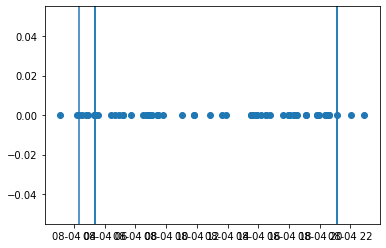

In [ ]:
# A way to visualize which and how many detections are lining up in time:
# Scatter plot the true time arrivals, and overlay the EQTransformer detections

# Filter to desired time band
new_enwf = new_enwf.loc[(new_enwf.ptime>startdate) & (new_enwf.ptime<enddate)]

fig,ax = plt.subplots()
ax.scatter(org_enwf['ENWF_S_time'],np.zeros(len(org_enwf)))

# Define successful EQTransformer detections as those that occur within 2 seconds of true detections
success = []
for i in org_enwf['ENWF_P_time']:
  differ = new_enwf['ptime'] - i
  if any(abs(differ)<timedelta(seconds=2)):
    success.append(min(abs(differ)))

S_success = []
for i in org_enwf['ENWF_S_time']:
  differ = new_enwf['stime'] - i
  if any(abs(differ)<timedelta(seconds=2)):
    S_success.append(min(abs(differ)))

for i in new_enwf['ptime'].dropna():
  ax.axvline(i) 


print(len(success))


In [ ]:
def calc_performance(true_data,new_data):
  '''
  Reads in two vectors/pandas columns in datetime format
  
  Inputs:

  true_data = vector containing the datetimes of a phase arrival (either P or S) as detected by traditional methods
  new_data = vector containing the datetimes of a phase arrival (either P or S) as detected by EQTransformer
  
  NOTE: true_data must be longer than new_data in the way the code is written. 

  Matches occur when the timing of one arrival is within 2 seconds of another
  
  Returns: 
  
  tp = number of true positives (number of matches)
  fn = number of false negatives (number of traditional method detections that did not have an EQTransformer match)
  fp = number of false positivies (number of EQTransformer detections that did not have a traditional detection match)
  '''
     success = []
     for i in true_data:
      differ = new_data - i
      if any(abs(differ)<timedelta(seconds=2)):
        success.append(min(abs(differ)))
     
     # True positive
     tp = len(success)
     # False negative
     fn = len(true_data) - len(success)
     # False positive
     fp = len(new_data) - len(success)
     # Precision
     prec = tp/(fp+tp)
     # Recall
     rec = tp / (tp + fn)
     # F1 score
     f1 = tp / (tp + (fn+fp)/2)

     return(tp,fn,fp)




In [ ]:
# Make a dataframe that includes the performance analytics for each station/phase pair
# Print out the results


success = pd.DataFrame(columns=['Station-Phase Pair','True Positives','False Negatives','False Positives'])
success['Station-Phase Pair'] = ['ENWF_P','ENWF_S','KEMF_P','KEMF_S','KEMO_P','KEMO_S','ENHR_P','ENHR_S']
success['True Positives'].iloc[0],success['False Negatives'].iloc[0],success['False Positives'].iloc[0] = calc_performance(org_enwf['ptime'],new_enwf['ptime'])
success['True Positives'].iloc[1],success['False Negatives'].iloc[1],success['False Positives'].iloc[1] = calc_performance(org_enwf['stime'],new_enwf['stime'])
success['True Positives'].iloc[2],success['False Negatives'].iloc[2],success['False Positives'].iloc[2] = calc_performance(org_kemf['ptime'],new_kemf['ptime'])
success['True Positives'].iloc[3],success['False Negatives'].iloc[3],success['False Positives'].iloc[3] = calc_performance(org_kemf['stime'],new_kemf['stime'])
success['True Positives'].iloc[4],success['False Negatives'].iloc[4],success['False Positives'].iloc[4] = calc_performance(org_kemo['ptime'],new_kemo['ptime'])
success['True Positives'].iloc[5],success['False Negatives'].iloc[5],success['False Positives'].iloc[5] = calc_performance(org_kemo['stime'],new_kemo['stime'])
success['True Positives'].iloc[6],success['False Negatives'].iloc[6],success['False Positives'].iloc[6] = calc_performance(org_enhr['ptime'],new_enhr['ptime'])
success['True Positives'].iloc[7],success['False Negatives'].iloc[7],success['False Positives'].iloc[7] = calc_performance(org_enhr['stime'],new_enhr['stime'])
print(success)

  Station-Phase Pair True Positives False Negatives False Positives
0             ENWF_P              2              79               3
1             ENWF_S              4              77               1
2             KEMF_P              4              77              16
3             KEMF_S              6              75              14
4             KEMO_P              5              76              11
5             KEMO_S              5              76              11
6             ENHR_P              3              78              42
7             ENHR_S              9              72              36


In [ ]:
# If analyzing the results of several detection runs, with different hyperparameters:

# Read in finished runs

# If in Google drive:
test_folder = '/content/gdrive/Shareddrives/ESS490_Spring2021/True False Parameter Results/Success_Results'
# If in github:
test_folder = 'krauss-repo/eq_project/ParameterIteration_Results/Success_Results'

test = pd.read_csv(test_folder+'/default_results')
test.columns
test.drop(columns='Unnamed: 0',inplace=True)
print('Default results:')
print(test)

test2 = pd.read_csv(test_folder+'/dt_03_results')
test2.columns
test2.drop(columns='Unnamed: 0',inplace=True)
print('Detection threshold 0.3:')
print(test2)

test3 = pd.read_csv(test_folder+'/bs_50_results')
test3.columns
test3.drop(columns='Unnamed: 0',inplace=True)
print('Batch size 50:')
print(test3)

Default results:
  Station-Phase Pair  True Positives  False Negatives  False Positives
0             ENWF_P               2               79                4
1             ENWF_S               5               76                1
2             KEMF_P               3               78                5
3             KEMF_S               6               75                2
4             KEMO_P               7               74                2
5             KEMO_S               6               75                3
6             ENHR_P               2               79                8
7             ENHR_S               9               72                1
Detection threshold 0.3:
  Station-Phase Pair  True Positives  False Negatives  False Positives
0             ENWF_P               2               79                4
1             ENWF_S               5               76                1
2             KEMF_P               4               77                5
3             KEMF_S               

In [ ]:
# Earthquake characteristic analysis - LOOKING AT THE DATA
# To see if there is a clear trend in the magnitudes of earthquakes that are successfully detected, etc.

def get_indices(true_data,new_data):
  success=[]

  counter = 0
  # Save indices of successful matches
  for i in true_data['ptime']:
    counter += 1
    differ = new_data['ptime'] - i
    if any(abs(differ)<timedelta(seconds=2)):
        # success.append(np.amin(abs(differ)))
        success.append(counter)
  counter = 0
  for i in true_data['stime']:
    counter += 1
    differ = new_data['stime'] - i
    if any(abs(differ)<timedelta(seconds=2)):
        # success.append(np.amin(abs(differ)))
        success.append(counter)
  
  return(success)

success1 = get_indices(org_enhr,new_enhr)
success2 = get_indices(org_enwf,new_enwf)
success3 = get_indices(org_kemf,new_kemf)
success4 = get_indices(org_kemo,new_kemo)
all=success1+success2+success3+success4
eq_stats = pd.DataFrame(columns=['Magnitude','nwp','nws'])
eq_stats['Magnitude'] = org_kemf['magnitude'].iloc[np.unique(all)]
eq_stats['nwp'] = org_kemf['nwp'].iloc[np.unique(all)]
eq_stats['nws'] = org_kemf['nws'].iloc[np.unique(all)]
print(eq_stats)

     Magnitude  nwp  nws
149   1.632591    2    4
150   0.338127    4    4
156   0.739630    3    4
157  -0.114712    3    4
161   0.967936    3    4
165        NaN    1    4
172   0.389003    4    4
173   0.248404    3    4
181   0.259680    3    4
189   0.036561    2    4
203  -0.310464    2    3
221  -0.068506    3    4
225        NaN    0    5
226   0.096432    1    4
